In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
total_length = 3000
test_data_division = 1000
simulated_data = np.sin(2 * np.pi * 25 * np.arange(0, 1, 1.0 / total_length)) + np.cos(2 * np.pi * 25 * np.arange(0, 1, 1.0 / total_length)) + np.random.normal(0, 0.7, total_length)

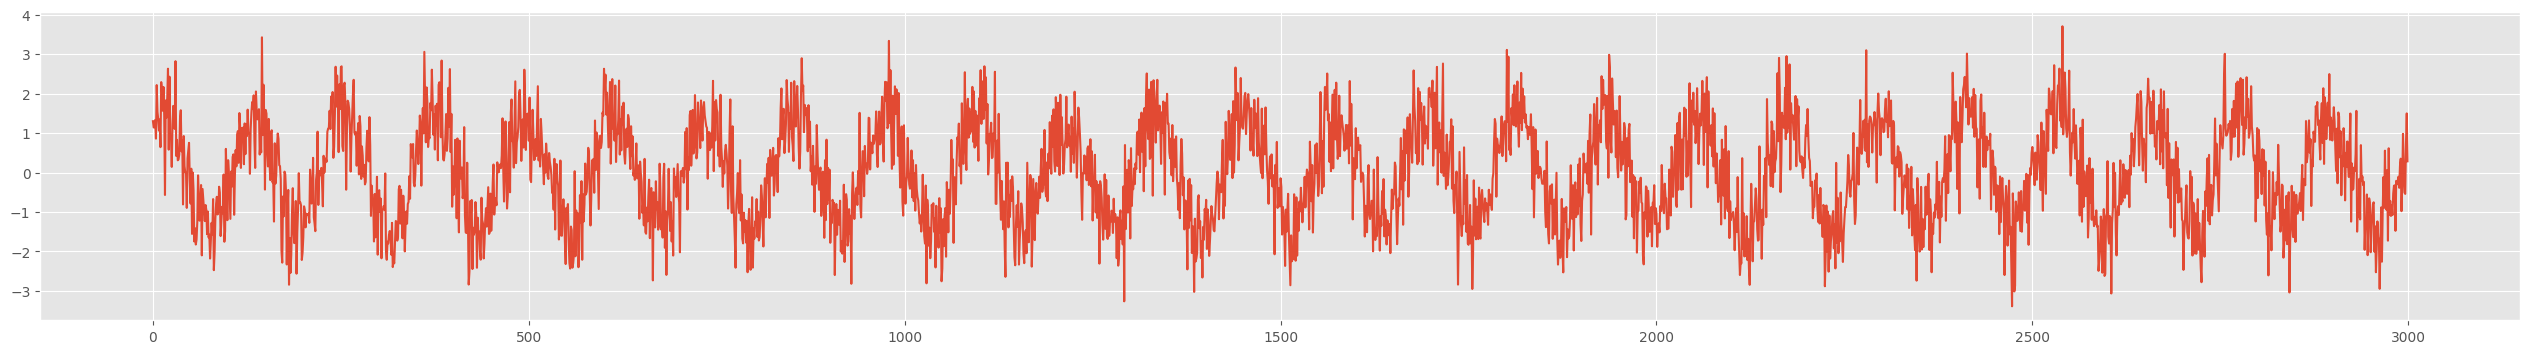

In [4]:
plt.style.use('ggplot')
plt.figure(figsize=(32, 4))
plt.plot(simulated_data)
plt.show()

In [5]:
batch_size = 21
in_window, out_window = 520, 168

train_data = simulated_data[:-test_data_division]
test_data = simulated_data[-test_data_division:]

print(train_data.shape, test_data.shape)

(2000,) (1000,)


In [6]:
train_mean, train_std = np.mean(train_data), np.std(train_data)
train_normalized = (train_data - train_mean) / train_std
test_normalized = (test_data - train_mean) / train_std

In [7]:
train_data_normalized = torch.FloatTensor(train_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_normalized).view(-1)

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class MyDataset(Dataset):
    def __init__(self, data, in_window, out_window):
        self.data = data
        self.in_l = in_window
        self.out_l = out_window

    def __len__(self):
        return len(self.data) - self.in_l - self.out_l

    def __getitem__(self, index):
        data = self.data[index : index + self.in_l]
        label = self.data[index + self.in_l : index + self.in_l + self.out_l]
        return data.reshape(self.in_l, 1), label

In [9]:
from torch.autograd import Variable
class LSTM(nn.Module):
    def __init__(self, out_size, input_size, hidden_size, num_layers=1):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output)
        return output[:, -1, :]

In [10]:
# in=1 because 1 feature
model = LSTM(input_size=1, out_size=out_window, hidden_size=out_window).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_set = MyDataset(data=train_data_normalized, in_window=in_window, out_window=out_window)
test_set = MyDataset(data=test_data_normalized, in_window=in_window, out_window=out_window)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

print(len(train_set), len(test_set))
print(model)

1312 312
LSTM(
  (lstm): LSTM(1, 168, batch_first=True)
  (fc): Linear(in_features=168, out_features=168, bias=True)
)


In [11]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params

143304

In [15]:
epoch = 50

for i in range(epoch):
    train_loss = 0
    model.train()
    model.to(device)

    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()

        y_pred = model(data)
        loss = loss_func(y_pred, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    if i % 10 == 1:
        test_loss = 0
        model.eval()

        for data, label in test_loader:
            model.to(torch.device('cpu'))
            data. label = data.cpu(), label.cpu()

            y_pred = model(data)
            loss = loss_func(y_pred, label)
            test_loss += loss.item()

        print(f"Epoch: {i}, Train Avg Loss: {train_loss / len(train_set)}, Test Avg Loss: {test_loss / len(test_set)}")

Epoch: 1, Train Avg Loss: 0.015303111680578895, Test Avg Loss: 0.01624451186030339
Epoch: 11, Train Avg Loss: 0.01528451793895262, Test Avg Loss: 0.016201062271228202
Epoch: 21, Train Avg Loss: 0.015303616707281368, Test Avg Loss: 0.016058246008096598
Epoch: 31, Train Avg Loss: 0.015247085586008503, Test Avg Loss: 0.016204200207422942
Epoch: 41, Train Avg Loss: 0.0152616961291287, Test Avg Loss: 0.01615034072444989


In [16]:
train_predict_list = []
train_truth_list = []

test_predict_list = []
test_truth_list = []

model.eval()
model.cpu()

LSTM(
  (lstm): LSTM(1, 168, batch_first=True)
  (fc): Linear(in_features=168, out_features=168, bias=True)
)

In [17]:
for index in range(0, len(train_data_normalized) - in_window - out_window, out_window):
    data = train_data_normalized[index : index + in_window]
    label = train_data_normalized[index + in_window : index + in_window + out_window]
    data = torch.FloatTensor(data.reshape(1, -1, 1))
    predicted = model(data)
    train_predict_list.extend(predicted.reshape(-1).tolist())
    train_truth_list.extend(label.reshape(-1).tolist())

for index in range(0, len(test_data_normalized) - in_window - out_window, out_window):
    data = test_data_normalized[index : index + in_window]
    label = test_data_normalized[index + in_window : index + in_window + out_window]
    data = torch.FloatTensor(data.reshape(1, -1, 1))
    predicted = model(data)
    test_predict_list.extend(predicted.reshape(-1).tolist())
    test_truth_list.extend(label.reshape(-1).tolist())

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mse = mean_squared_error(test_predict_list, test_truth_list)
mae = mean_absolute_error(test_predict_list, test_truth_list)
print(f"MSE: {mse}, MAE: {mae}")

MSE: 0.3468086760823723, MAE: 0.4661986779752797


In [21]:
train_test_division = len(train_predict_list)

all_predict = train_predict_list
train_predict_list.extend(test_predict_list)

all_truth = train_truth_list
train_truth_list.extend(test_truth_list)

df_vis = pd.DataFrame({
    'index': [i for i in range(0, len(all_truth))],
    'predict': all_predict,
    'truth': all_truth
})

<Figure size 2400x600 with 0 Axes>

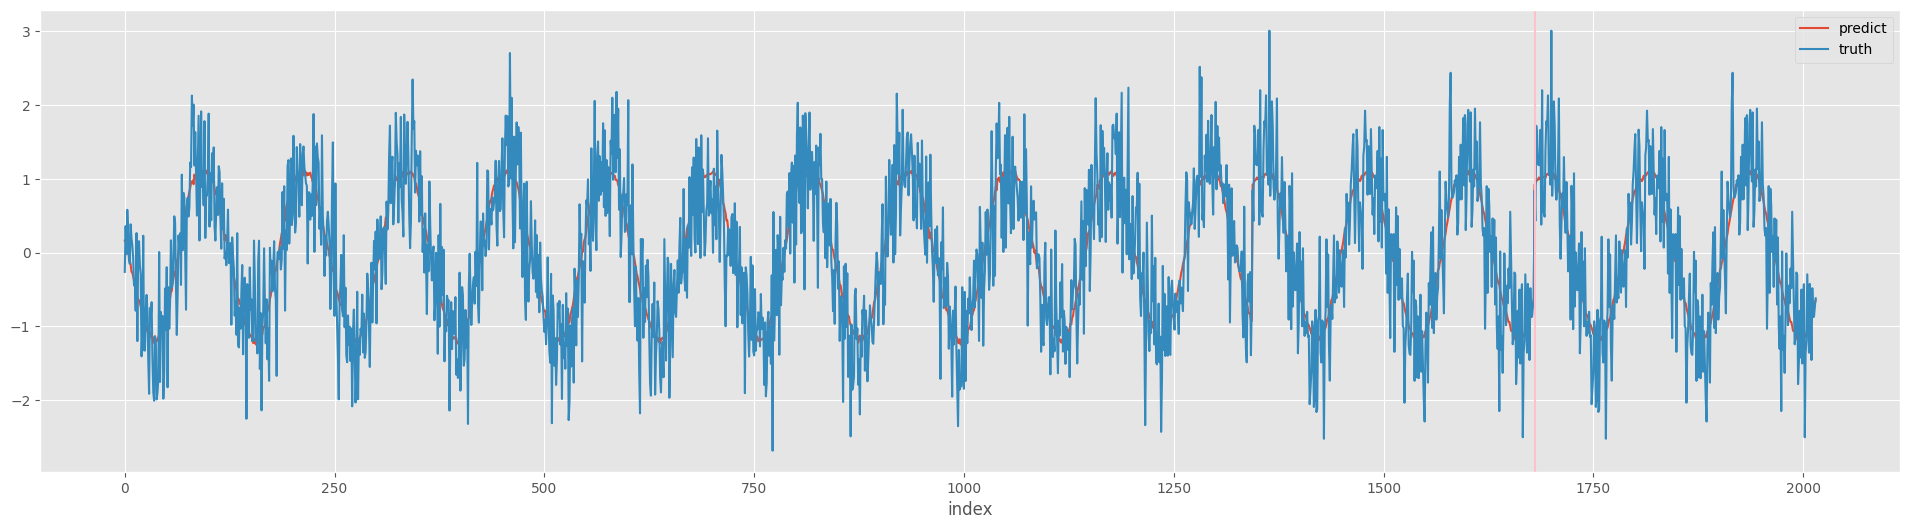

In [22]:
plt.figure(figsize=(24, 6))
df_vis.plot(x='index', y=['predict', 'truth'], figsize=(24, 6))
plt.axvline(x=train_test_division, color="pink")
plt.show()

<Figure size 2400x600 with 0 Axes>

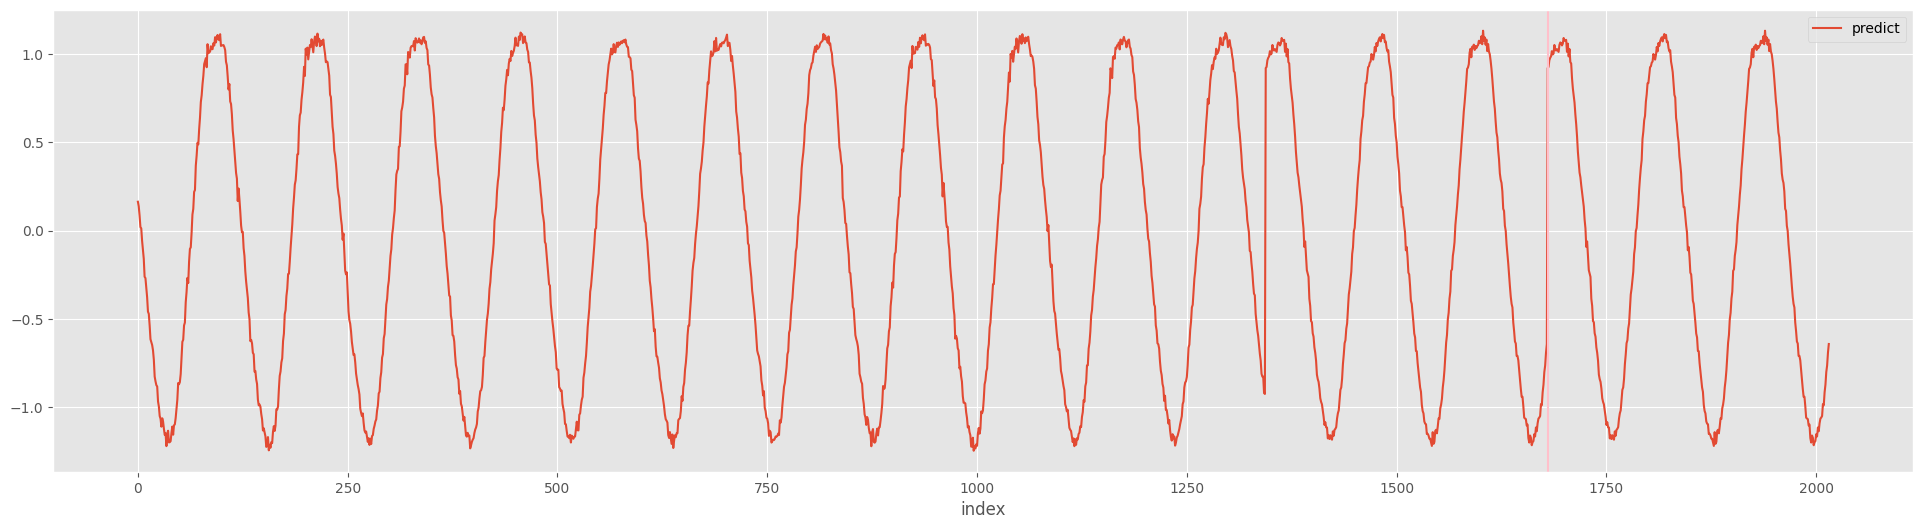

In [23]:
plt.figure(figsize=(24, 6))
df_vis.plot(x='index', y=['predict'], figsize=(24, 6))
plt.axvline(x=train_test_division, color="pink")
plt.show()